# Проект интернет-магазина "Стримчик".

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности для того чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании на 2017 год с помощью имеющихся данных, собранных до 2016 года.

### Общая информация о данных.

Рассмотрим предоставленный файл с данными и изучим общую информацию.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

df = pd.read_csv('/datasets/games.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [2]:
df.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


В данных содержится 16713 наименований игр. Наибольший недостаток данных составляют колонки, определяющие оценки критиков и пользовательские оценки, а также колонка рейтинга от организации ESRB. Можно заметить, что названия колонок оформлены не в нижнем регистре. Также в данных для некоторых колонок определен не подходящий для них тип, так, например, год выпуска игры указан как тип float. Разберемся с этими нюансами на этапе подготовки данных к анализу.  

### Подготовка данных к анализу.

#### Замена названий столбцов.

Приведем названия колонок к нижнему регистру для соблюдения стандартов стилистки и удобной работы с ними.

In [3]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

#### Обработка пропусков.

Можно заметить, что в данных содержится две строки без указания названия игры, и жанра. Избавимся от них.

In [4]:
df.dropna(subset=['name'], inplace=True)

In [5]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце `user_score` встречается аббревиатура 'tbd', что вероятно означает 'to be determined', то есть 'предстоит определить'. Возможно в некоторых играх с такой оценкой не было системы для оценки пользователями или же игра просто не была выпущена в релиз, в любом случае, так как у нас есть полные данные о продажах игр, заменим аббревиатуру на значение NaN и оставим пропуски без изменений.  

In [6]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan

Пустые значения в столбце с годом выпуска, а также пропуски в столбцах `critic_score`, `user_score`, `rating` мы не можем заполнить средним или каким либо еще значением, так как это может исказить результаты дальнейшего анализа (и в целом было бы не логично). К пропускам в данных столбцах могли привести технические неполадки, либо отразился человеческий фактор, а в столбце `year_of_release` год мог быть указан в названии. Мы не можем просто удалить строки, в которых отсутствуют данные в указанных столбцах, потому что другие данные могут быть полезными для анализа, поэтому заменим пустые значения в колонках `year_of_release`, `critic_score`, `user_score` на -1 для того чтобы преобразовать их в более подходящий тип данных.  

In [7]:
for col in ['year_of_release', 'critic_score', 'user_score']:
    df[col] = df[col].fillna(-1)

#### Преобразование типов.

В некоторых колонках, таких как: `year_of_release`, `critic_score` тип данных определен как float несмотря на то, что в данных используются целые числа (тип int), а в столбце `user_score` и указан строковый тип данных, однако данные предоставлены в числах типа float. 

In [8]:
for col in ['year_of_release', 'critic_score']:
    df[col] = df[col].astype(int)

In [9]:
df['user_score'] = df['user_score'].astype(float) 

#### Суммарные продажи.

Создадим новый столбец `total_sales` в котором будет рассчитана сумма продаж игр во всех регионах.

In [10]:
df['total_sales'] = df.loc[:, 'na_sales': 'other_sales'].apply('sum', axis=1)

In [11]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,NaN,31.38


### Исследовательский анализ данных.

#### Продажи и выпуск игр и  в зависимости от года.

Рассмотрим какое количество игр выпускалось в зависимости от года.

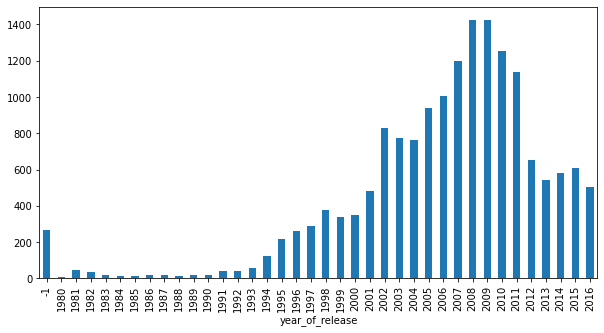

In [12]:
df.groupby('year_of_release')['name'].count().plot(kind='bar', figsize=(10, 5))
plt.show()

Мы видим на графике, что активный рост выпуска видеоигр начался с 1994 года вплоть до 2010, затем можно заметить резкий спад в 2012 года уровень производства в котором держится в настоящий момент. Так как мы собираемся использовать данные для прогноза на 2017 год, для анализа нам более интересен период с 2012 года, в котором производство видеоигр держится на примерно одинаковом уровне и при этом выпускаются игры для еще не устаревших платформ.

______

Рассмотрим как менялись продажи по игровым платформам в зависимости от года.

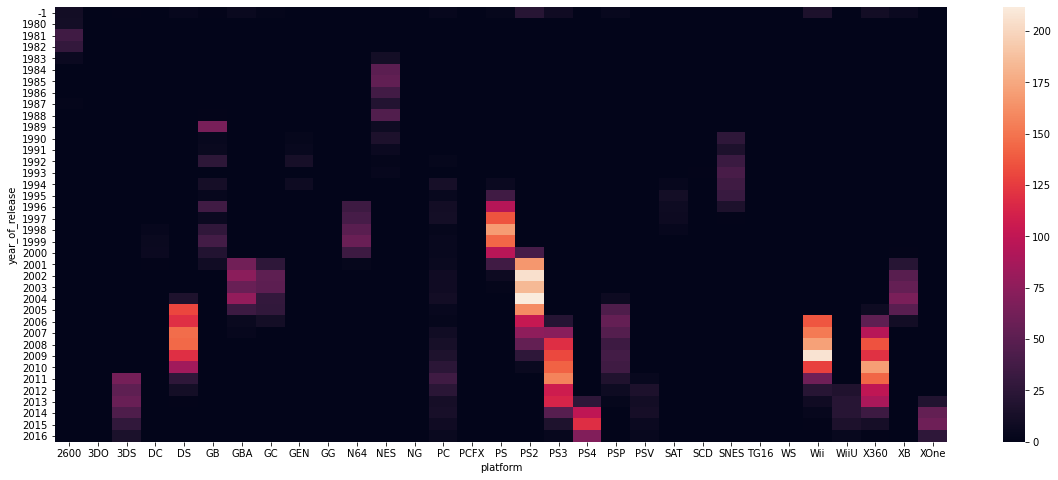

In [13]:
plt.figure(figsize=(20, 8))
sns.heatmap(df.pivot_table(index='year_of_release', values='total_sales', columns='platform', aggfunc='sum').fillna(0))
plt.show()

Для анализа продаж мы будем рассматривать платформы с наибольшими суммарными продажами игр (свыше 50 млн продаж игр платформы за год), базу данных с такими платформами назовем `top_sales_platforms`

In [14]:
top_sales_platforms = df.pivot_table(index=['year_of_release', 'platform'], values='total_sales', aggfunc='sum').query('total_sales > 50').reset_index()
top_sales_platforms.head(5)

,year_of_release,platform,total_sales
0,1984,NES,50.08
1,1985,NES,53.44
2,1989,GB,64.97
3,1996,PS,94.70
4,1997,PS,136.17


Рассмотрим график продаж игр популярных платформ в зависимости от года

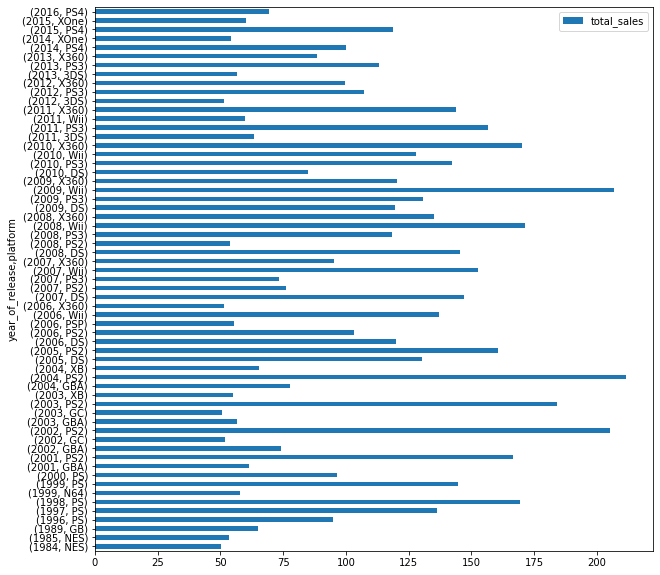

In [15]:
df.pivot_table(index=['year_of_release', 'platform'], values='total_sales', aggfunc='sum').query('total_sales > 50').plot(kind='barh', figsize=(10, 10))
plt.show()

Данный график позволяет визуально оценить какие платформы доминируют на рынке в определенный год. Также исходя из графика можно разглядеть тенденцию в переодичности появления новых и исчезновения старых игровых платформ

#### Периодичность выхода и исчезновения игровых платформ.

Рассмотрим даты выхода популярных платформ. 

In [16]:
year_of_top_platform_release = dict()

for platform in top_sales_platforms['platform'].unique():
    year_of_top_platform_release[platform] = df[(df['platform'] == platform) & (df['year_of_release'] != -1)]['year_of_release'].min() 

sorted(year_of_top_platform_release.items())

[('3DS', 2011),
 ('DS', 1985),
 ('GB', 1988),
 ('GBA', 2000),
 ('GC', 2001),
 ('N64', 1996),
 ('NES', 1983),
 ('PS', 1994),
 ('PS2', 2000),
 ('PS3', 2006),
 ('PS4', 2013),
 ('PSP', 2004),
 ('Wii', 2006),
 ('X360', 2005),
 ('XB', 2000),
 ('XOne', 2013)]

Вычислим приблизительную периодичность с которой выпускаются новые платформы.

In [17]:
np.diff(list(year_of_top_platform_release.values())).mean()
    

2.0

Получается, что в среднем новые популярные игровые платформы появляются каждые 2 года.

__________________

Рассмотрим годы завершения выпуска игр для популярных платформ.

In [18]:
max_year_of_top_platform_release = dict()

for platform in top_sales_platforms['platform'].unique():
    max_year_of_top_platform_release[platform] = df[(df['platform'] == platform) & (df['year_of_release'] != -1)]['year_of_release'].max() 

sorted(max_year_of_top_platform_release.items())

[('3DS', 2016),
 ('DS', 2013),
 ('GB', 2001),
 ('GBA', 2007),
 ('GC', 2007),
 ('N64', 2002),
 ('NES', 1994),
 ('PS', 2003),
 ('PS2', 2011),
 ('PS3', 2016),
 ('PS4', 2016),
 ('PSP', 2015),
 ('Wii', 2016),
 ('X360', 2016),
 ('XB', 2008),
 ('XOne', 2016)]

Чтобы рассчитать периодчность исчезновения популярных платформ, нам необходимо избавиться от до сих пор актуальных моделей, таковыми являются PS4, XOne, 3DS, PS3, Wii, X360.

In [19]:
del max_year_of_top_platform_release['PS4']
del max_year_of_top_platform_release['XOne']
del max_year_of_top_platform_release['3DS']
del max_year_of_top_platform_release['PS3']
del max_year_of_top_platform_release['Wii']
del max_year_of_top_platform_release['X360']


Вычислим приблизительную периодичность с которой выпускаются новые платформы.

In [20]:
np.diff(list(max_year_of_top_platform_release.values())).mean()

2.3333333333333335

Получается, что в среднем популярные игровые платформы исчезают с рынка каждые 2.3 года. Так как момент выхода новых платформ меньше момента исчезновений, это может означать, что пользователи некоторое время продолжают пользоваться платформами, на которые уже не выпускаются новые игры, что вполне логично.

Рассмотрим несколько популярных платформ с наибольшими суммарными продажами видеоигр для того чтобы определить примерный срок жизни игровой платформы. Для примера возьмем топ-5 платформ с наибольшим количеством проданных копий видеоигр.

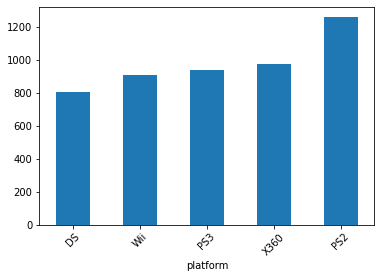

In [21]:
df.groupby('platform')['total_sales'].agg('sum').sort_values().tail().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

В топ-5 попали: "PS2", "X360", "PS3", "Wii", "DS". Построим по каждой платформе распределение продаж по годам.

Рассмотрим график распределения продаж в зависимости от года для "PS2"

<AxesSubplot:xlabel='year_of_release'>

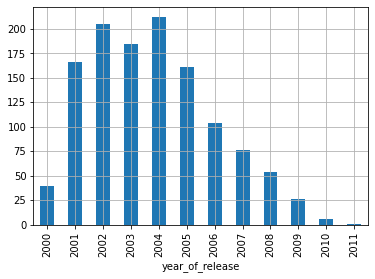

In [22]:
df.query('platform == "PS2" and year_of_release != -1').groupby('year_of_release')['total_sales'].agg('sum').plot(kind='bar', grid=True)

Судя по графику, примерный срок жизни игровой платформы "PS2" составил с 2000 по 2009 год, то есть 9 лет.

_____

Рассмотрим график распределения продаж в зависимости от года для "X360".

<AxesSubplot:xlabel='year_of_release'>

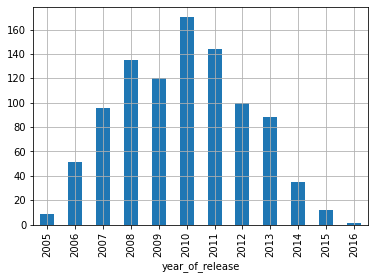

In [23]:
df.query('platform == "X360" and year_of_release != -1').groupby('year_of_release')['total_sales'].agg('sum').plot(kind='bar', grid=True)

Судя по графику, примерный срок жизни игровой платформы "X360" составил с 2005 по 2015 год, то есть 10 лет.

-----

Рассмотрим график распределения продаж в зависимости от года для "PS3".

<AxesSubplot:xlabel='year_of_release'>

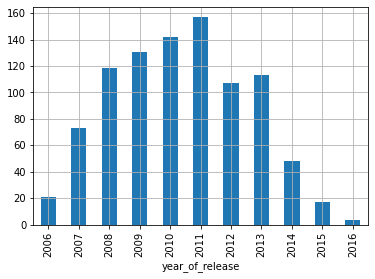

In [24]:
df.query('platform == "PS3" and year_of_release != -1').groupby('year_of_release')['total_sales'].agg('sum').plot(kind='bar', grid=True)

Судя по графику, примерный срок жизни игровой платформы "PS3" составил с 2006 по 2015 год, то есть 9 лет.

-----

Рассмотрим график распределения продаж в зависимости от года для "Wii".

<AxesSubplot:xlabel='year_of_release'>

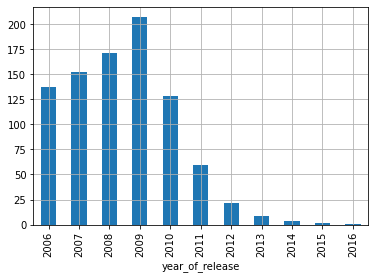

In [25]:
df.query('platform == "Wii" and year_of_release != -1').groupby('year_of_release')['total_sales'].agg('sum').plot(kind='bar', grid=True)

Судя по графику, примерный срок жизни игровой платформы "Wii" составил с 2006 по 2012 год, то есть 6 лет.

-----

Рассмотрим график распределения продаж в зависимости от года для "DS".

<AxesSubplot:xlabel='year_of_release'>

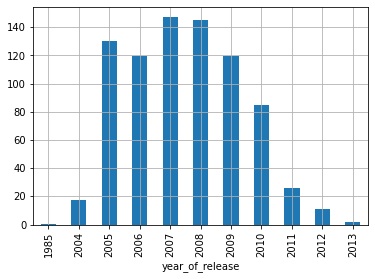

In [26]:
df.query('platform == "DS" and year_of_release != -1').groupby('year_of_release')['total_sales'].agg('sum').plot(kind='bar', grid=True)

Судя по графику, примерный срок жизни игровой платформы "DS" составил с 2004 по 2012 год, то есть 8 лет.

#### Анализ продаж в актуальный период.

В главе 3.1 мы обозначили актуальным период с 2012 по 2016 год. Создадим новый датафрейм `actual_df` с данными, содержащими игры выпущенные после 2011 года.

In [27]:
actual_df = df.query('year_of_release >= 2013')

Рассмотрим объем продаж игр в зависимости от игровой платформы.

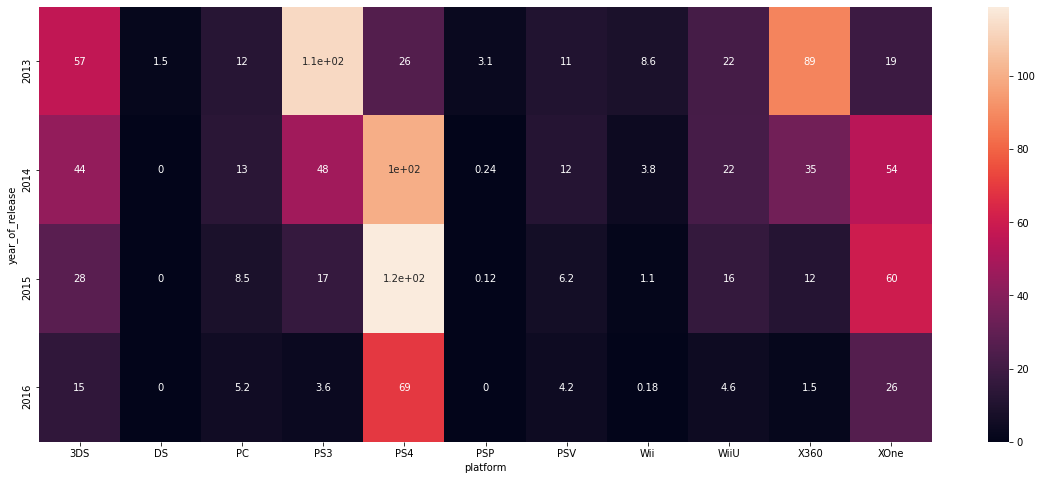

In [28]:
plt.figure(figsize=(20, 8))
sns.heatmap(actual_df.pivot_table(index='year_of_release', values='total_sales', columns='platform', aggfunc='sum').fillna(0), annot=True)
plt.show()

В большом отрыве от остальных, первые позиции на актуальный момент разделяют две платформы: PS4 и XOne, у которых практически не остается конкурентов, так как количество продаж игр остальных платформ заметно снизилось к настоящему моменту.

_____

Рассмотрим диаграммы размаха продаж игр различных игровых платформ для того чтобы визуально оценить какие платформы имеют игры, продажи которых сильно превосходят обычные значения.

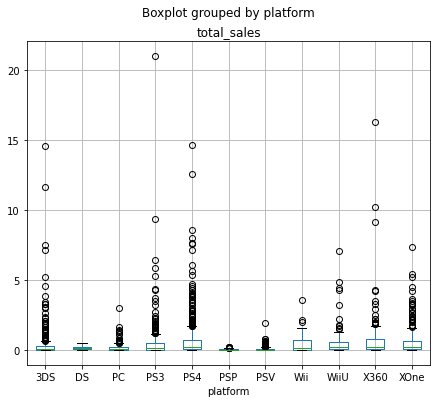

In [29]:
actual_df.boxplot(column='total_sales', by='platform', figsize=(7, 6))
plt.show()

На графике можно увидеть, что такие платформы, как 3DS, PS3, PS4, X360 имеют хитовые игры, продажи которых превышают 10 млн. копий, чем явно не могут похвастать такие платформы как DS, PSP, PSV.

Сравним медианные показатели продаж.

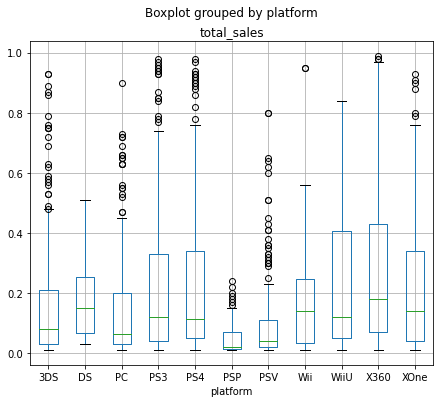

In [30]:
actual_df.query('total_sales < 1').boxplot(column='total_sales', by='platform', figsize=(7, 6))
plt.show()

Как мы видим, наиболее высокие показатели остаются за PS3, PS4, Wii, WiiU, X360 и XOne.

#### Влияние отзывов на продажи.

Постараемся выяснить как отзывы обычных пользователей и отзывы критиков влияют на продажи. Объектом исследования будет самая популярная на данный момент платформа - PS4.

Для анализа воспользуемся диаграммой рассеяния и рассмотрим корреляцию между показателями.

Создадим новый датафрейм `ps4_df`, содержащий только игры для платформы PS4.

Рассмотрим корреляцию продаж в зависимости от оценок критиков.

In [32]:
ps4_df = df.query('platform == "PS4"')

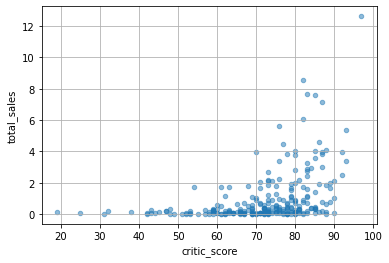

In [34]:
ps4_df.query('critic_score != -1').plot.scatter(x='critic_score', y='total_sales', grid=True, alpha=0.5)
plt.show()

In [35]:
ps4_df.query('critic_score != -1').loc[:, ['critic_score', 'total_sales']].corr()

,critic_score,total_sales
critic_score,1.000000,0.406568
total_sales,0.406568,1.000000


Наблюдается слабая положительная корреляция между оценкой критиков и количеством продаж видеоигр.

Рассмотрим корреляцию продаж в зависимости от оценок пользователей.

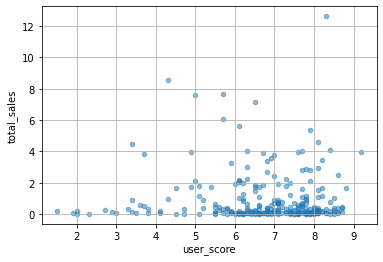

In [36]:
ps4_df.query('user_score != -1').plot.scatter(x='user_score', y='total_sales', grid=True, alpha=0.5)
plt.show()

In [37]:
ps4_df.query('user_score != -1').loc[:, ['user_score', 'total_sales']].corr()

,user_score,total_sales
user_score,1.000000,-0.031957
total_sales,-0.031957,1.000000


Корреляция между оценками пользователей и продажами игр практически отсутствует.

Таким образом на количество продаж влияет оценка игр выставленная критиками, в отличие от оценок пользователей, которая практически не влияет на количество продаж. Игры в большинстве случаев выпускаются одновременно для нескольких платформ, поэтому результаты можно интерпретировать и для других игровых платформ. 

Рассмотрим корреляцию в целом на других платформах в зависимости от оценок критиков.

In [38]:
actual_df.query('critic_score != -1 and platform != "PS4"').loc[:, ['critic_score', 'total_sales']].corr()

,critic_score,total_sales
critic_score,1.000000,0.281251
total_sales,0.281251,1.000000


Рассмотрим корреляцию в целом на других платформах в зависимости от оценок пользователей.

In [39]:
actual_df.query('user_score != -1 and platform != "PS4"').loc[:, ['user_score', 'total_sales']].corr()

,user_score,total_sales
user_score,1.000000,-0.001122
total_sales,-0.001122,1.000000


Как мы видим, на других платформах также прослеживается слабая, однако менее выраженная положительная корреляция между оценкой критиков и количеством продаж по сравнению с самой популярной игровой платформой. Корреляция между оценками пользователей и продажами игр также практически отсутствует.

#### Прибыльность игр в зависимости от жанра.

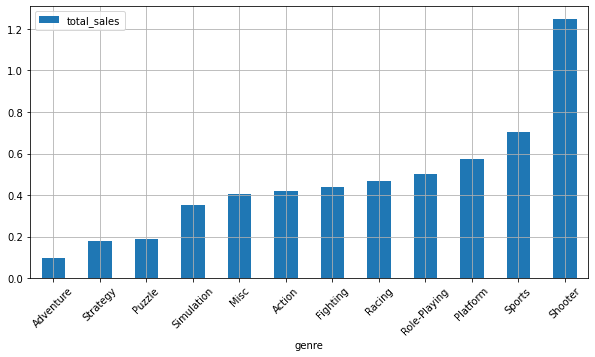

In [40]:
actual_df.pivot_table(index='genre', values='total_sales').sort_values('total_sales').plot(kind='bar', grid=True, figsize=(10, 5))
plt.xticks(rotation=45)
plt.show()

Как мы видим из графика, самым популярным жанром является "Shooter", наименее популярными жанрами являются "Adventure", "Puzzle" и "Strategy". 

### Портрет пользователя.

Создадим отдельные датафреймы для каждого региона продаж `na_df`, `eu_df` и `jp_df`, в которых будут собраны данные об играх наиболее популярных именно в его регионе.

In [41]:
na_df = actual_df.query('na_sales > eu_sales and na_sales > jp_sales')
eu_df = actual_df.query('eu_sales > na_sales and eu_sales > jp_sales')
jp_df = actual_df.query('jp_sales > na_sales and jp_sales > eu_sales')

#### Самые популярные платформы.

Самые популярные платформы (топ-5) Северной Америки

In [42]:
actual_df.groupby('platform')['na_sales'].sum().sort_values().tail()

platform
3DS      38.20
PS3      63.50
X360     81.66
XOne     93.12
PS4     108.74
Name: na_sales, dtype: float64

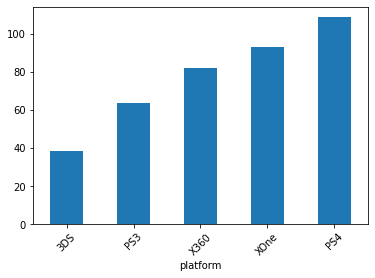

In [43]:
actual_df.groupby('platform')['na_sales'].sum().sort_values().tail().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

Самой популярной игровой платформой в Северной Америке оказалась "PS4", за ней следуют "XOne", "X360", "PS3", "3DS".

________

Самые популярные платформы (топ-5) Европы.

In [44]:
actual_df.groupby('platform')['eu_sales'].sum().sort_values().tail()

platform
3DS      30.96
X360     42.52
XOne     51.59
PS3      67.81
PS4     141.09
Name: eu_sales, dtype: float64

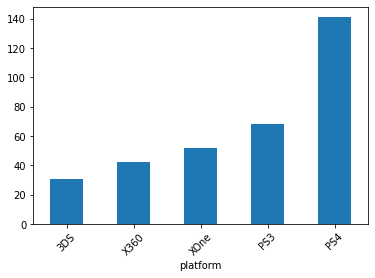

In [45]:
actual_df.groupby('platform')['eu_sales'].sum().sort_values().tail().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

В Европе первое место занимает "PS4" в довольно большом отрыве от менее популярных "PS3", "XOne", "X360", "3DS".

___________

Самые популярные платформы (топ-5) Японии.

In [46]:
actual_df.groupby('platform')['jp_sales'].sum().sort_values().tail()

platform
WiiU    10.88
PS4     15.96
PSV     18.59
PS3     23.35
3DS     67.81
Name: jp_sales, dtype: float64

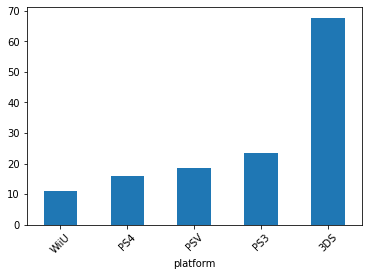

In [47]:
actual_df.groupby('platform')['jp_sales'].sum().sort_values().tail().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

В Японии лидирующую позицию по продажам игр занимет платформа "3DS". за ней следуют "PS3", "PSV", "PS4", "WiiU".

#### Самые популярные жанры.

Самые популярные жанры (топ-5) Северной Америки.

In [48]:
actual_df.groupby('genre')['na_sales'].sum().sort_values().tail()

genre
Misc             27.49
Role-Playing     46.40
Sports           65.27
Shooter         109.74
Action          126.05
Name: na_sales, dtype: float64

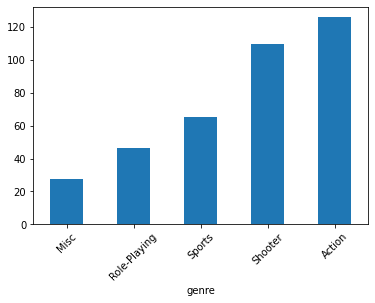

In [49]:
actual_df.groupby('genre')['na_sales'].sum().sort_values().tail().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

Лидирующее место среди игровых жанров в Северной Америке занимает "Action", чуть менее популярным оказался жанр "Shooter".  Жанры "Sports", "Role-Playing", "Misc" находятся в конце списка.

-----

Самые популярные жанры (топ-5) Европы.

In [50]:
actual_df.groupby('genre')['eu_sales'].sum().sort_values().tail()

genre
Racing           20.19
Role-Playing     36.97
Sports           60.52
Shooter          87.86
Action          118.13
Name: eu_sales, dtype: float64

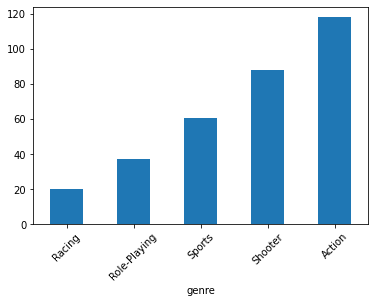

In [51]:
actual_df.groupby('genre')['eu_sales'].sum().sort_values().tail().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

В Европе, как и в Америке, лидирующим жанром является "Action", за ним с небольшим следует жанр "Shooter", следом  идут жанры "Sports", "Role-Playing", "Racing".

________________

Самые популярные жанры (топ-5) Японии.

In [52]:
actual_df.groupby('genre')['jp_sales'].sum().sort_values().tail()

genre
Shooter          6.61
Fighting         7.65
Misc             9.20
Action          40.49
Role-Playing    51.04
Name: jp_sales, dtype: float64

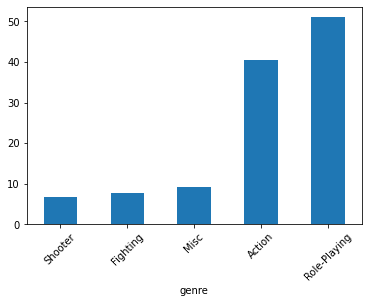

In [53]:
actual_df.groupby('genre')['jp_sales'].sum().sort_values().tail().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

В Японии лидирующее место занимает жанр "Role-Playing", второе место за жанром "Action", затем в большом отрыве располагаются жанры "Misc", "Fightning" и "Shooter".

#### Влияние рейтинга ESRB на продажи.

In [54]:
na_rating = actual_df.pivot_table(index='rating', values='na_sales')
na_rating['fraction'] = na_rating['na_sales'].agg(lambda x: x / na_rating['na_sales'].sum()).round(2)
na_rating

,na_sales,fraction
rating,,
E,0.261755,0.24
E10+,0.215238,0.20
M,0.447724,0.42
T,0.149520,0.14


В Северной Америке больше всего игр было продано с рейтингом "M".

In [55]:
eu_rating = actual_df.pivot_table(index='rating', values='eu_sales')
eu_rating['fraction'] = eu_rating['eu_sales'].agg(lambda x: x / eu_rating['eu_sales'].sum()).round(2)
eu_rating

,eu_sales,fraction
rating,,
E,0.276026,0.29
E10+,0.169405,0.18
M,0.393821,0.41
T,0.125976,0.13


В Европе также больше всего игр было продано с рейтингом "M".

In [56]:
jp_rating = actual_df.pivot_table(index='rating', values='jp_sales')
jp_rating['fraction'] = jp_rating['jp_sales'].agg(lambda x: x / jp_rating['jp_sales'].sum()).round(2)
jp_rating

,jp_sales,fraction
rating,,
E,0.050132,0.29
E10+,0.023373,0.13
M,0.038238,0.22
T,0.061832,0.36


В Японии же ситуация отличается от Северной Америки и Европы, в лидирующие позиции занимают игры с рейтингом T.

### Проверка гипотез.

#### Гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковы.

Сформулируем нулевую гипотезу: средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC. В таком случае альтернативная гипотеза будет гласить, что средний пользовательский рейтинг платформы Xbox One не равен среднему пользовательскому рейтингу платформы PC.

Создадим датафрейм `xone_df` содержащий игры для Xbox One и датайфрейм `pc_df` содержащий игры для PC. 

In [57]:
xone_df = actual_df.query('user_score != -1 and platform == "XOne"')
pc_df = actual_df.query('user_score != -1 and platform == "PC"')

Для проверки гипотезы воспользуемся функцией `ttest_ind`, позволяющей определить p-value и оценить вероятность расхождения средних значений. В случае если значение p-value меньше 5%, то мы отвергнем нулевую гипотезу о равенстве пользовательских рейтингов.

In [58]:
st.ttest_ind(xone_df['user_score'], pc_df['user_score'], equal_var=False).pvalue

0.14759594013430463

Уровень значимости (p-value) между средними показателями пользовательских рейтингов двух платформ составляет около 15%, что явно превышет контрольный показатель в 5% из чего следует, что полученные результаты не противоречат нулевой гипотезе, мы не можем ее отклонить.

#### Гипотеза: Средние пользовательские рейтинги жанров Action и Sports разные.

Сформулируем нулевую гипотезу: средний пользовательский рейтинг жанра Action отличается от среднего пользовательского рейтинга жанра Sports. В таком случае альтернативная гипотеза будет гласить, что средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports.

Создадим датафрейм `action_df` содержащий игры жанра "Action" и датайфрейм `sports_df` содержащий игры жанра "Action". 

In [59]:
action_df = actual_df.query('genre == "Action"')
sports_df = actual_df.query('genre == "Sports"')

Для проверки гипотезы воспользуемся функцией `ttest_ind`, позволяющей определить p-value и оценить вероятность расхождения средних значений. В случае если значение p-value меньше 5%, то мы не отвергаем нулевую гипотезу о неравенстве пользовательских рейтингов. 

In [60]:
st.ttest_ind(action_df['user_score'], sports_df['user_score'], equal_var=False).pvalue

0.008445505365573197

Уровень значимости (p-value) между средними показателями пользовательских рейтингов двух платформ составляет около 0.08%, что явно меньше контрольного показателя 5%. Полученные результаты не позволяют отклонить нулевую гипотезу.

### Общий вывод.

В рамках данного проекта были произведены исследования основанные на данных, предоставленных интернет-магазином "Стримчик". Целью проекта было выявление закономерностей определяющих успешность игр, для того чтобы спланировать будущие рекламные компании. 

В предоставленных данных содержалось 16713 наименований игр с указанием года релиза, жанра, игровой платформы, количеством продаж в разных регионах, оценками пользователей и критиков, а также рейтинг организации ESRB. Наибольший недостаток данных составляли колонки, определяющие оценки критиков и пользовательские оценки, а также колонка рейтинга от организации ESRB. В ходе подготовки данных к анализу мы обработали пропуски, заменили тип данных на более подходящий, а также добавили новый столбец в котором находились данные об общих продажах.

В ходе исследования был проведен анализ продаж игр в зависимости от года выпуска. В ходе которого выяснилось, что активный рост выпуска видеоигр начался с 1994 года вплоть до 2010, затем начался резкий спад продаж, в 2012 году уровень производства держится на стабильном уровне. Для актуального анализа был взят период именно с 2013 года, в котором производство видеоигр держится на примерно одинаковом уровне и при этом выпускаются игры для еще не устаревших платформ.

Анализируя даты выхода игр для новых платформ, мы смогли вычислить, что новые (становящиеся популярными) платформы появляются примерно каждые два года. Также мы смогли выяснить, что в среднем популярные игровые платформы исчезают с рынка каждые 2.3 года. В среднем, жизнь популярной игровой платформы равняется примерно 8.4 годам. Пик роста продаж игр приходится на первые 3-4 года после выхода платформы.

Далее были рассмотрены общие продажи игр различных платформ за актуальный период, в ходе чего выяснилось, что в большом отрыве от остальных, первые позиции на актуальный момент разделяют две платформы: PS4 и XOne, у которых практически не остается конкурентов, так как количество продаж игр остальных платформ заметно снизилось к настоящему моменту. Также мы выяснили, что такие платформы, как 3DS, PS3, PS4, X360 имеют хитовые игры, продажи которых превышают 10 млн. копий, чем явно не могут похвастать такие платформы как DS, PSP, PSV, а также сравнили медианные показатели продаж, наиболее высокими показателями смогли похвастаться PS3, PS4, Wii, WiiU, X360 и XOne.

Затем мы постарались изучить то, как отзывы обычных пользователей и отзывы критиков влияют на продажи. В ходе исследования выяснилось, что на количество продаж влияет оценка игр выставленная критиками, в отличие от оценок пользователей, которая практически не влияет на количество продаж. 

Также были рассмотрены различные жанры игр, самым популярным жанром оказался "Shooter", наименее популярными жанрами  среди пользователей оказались "Adventure", "Puzzle" и "Strategy". 

Мы попробовали составить портрет пользователя  определенного региона, исходя из количества игр наиболее популярных в каждом регионе. Самой популярной игровой платформой в Северной Америке оказалась "PS4", за ней следуют "XOne", "X360", "PS3", "3DS". Лидирующее место среди игровых жанров в Северной Америке занимает "Action", чуть менее популярным оказался жанр "Shooter". Жанры "Sports", "Role-Playing", "Misc" находятся в конце списка. Исходя из рейтинга ESRB больше всего игр было продано с рейтингом "M", как и в Европе.

В Европе первое место занимает "PS4" в довольно большом отрыве от менее популярных "PS3", "XOne", "X360", "3DS". В Европе, как и в Америке, лидирующим жанром является "Action", за ним с небольшим следует жанр "Shooter", следом идут жанры "Sports", "Role-Playing", "Racing".

В Японии лидирующую позицию по продажам игр занимет платформа "3DS". за ней следуют "PS3", "PSV", "PS4", "WiiU". В Японии лидирующее место занимает жанр "Role-Playing", второе место за жанром "Action", затем в большом отрыве располагаются жанры "Misc", "Fightning" и "Shooter". Исходя из рейтинга ESRB в Японии ситуация отличается от Северной Америки и Европы, в лидирующие позиции занимают игры с рейтингом T.

В ходе проверки гипотез нам не удалось отвергнуть гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, также мы не смогли отвергнуть гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports разные.

Исходя из проведенного исследования, для планирования рекламной кампании на 2017 год можно предоставить некоторые рекомендации. Рекламной компании следует сосредоточить свое внимание на наиболее популярных и все еще развивающихся платформах на данный момент - PS4 и XOne, жанр "Shooter" - лидирующий жанр в отрыве от остальных. В зависимости от регионов ситуация меняется, следует это учитывать.